In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
#import pandas_profiling
%matplotlib inline

In [2]:
train_ = pd.read_csv('./data/train.csv',index_col=0)
test_ = pd. read_csv('./data/test.csv',index_col=0)
sample_submission = pd.read_csv('./data/sample_submission.csv', index_col=0)

데이터 설명

-     대전지역에서 측정한 실내외 19곳의 센서데이터와, 주변 지역의 기상청 공공데이터를 semi-비식별화하여 제공합니다. 
-     센서는 온도를 측정하였습니다. 
-     모든 데이터는 시간 순으로 정렬 되어 있으며 10분 단위 데이터 입니다. 
-     예측 대상(target variable)은 Y18입니다. 

train.csv 

-     30일 간의 기상청 데이터 (X00 ~ X39) 및 센서데이터 (Y00~Y17)
-     이후 3일 간의 기상청 데이터 (X00~X39) 및 센서데이터 (Y18)

test.csv 
-     train.csv 기간 이후 80일 간의 기상청 데이터 (X00~X39)

sample_submission.csv
-     제출 양식 예시

X00 X07 X28 X31 기온  
X01 X06 X22 X27 기압  
X02 X03 X18 X24 풍속  
X04 X10 X21 X36 누적강수량  
X05 X08 X09 X23 해면기압  
X11 X14 X16 X19 누적일사량  
X12, X20, X30, X37 습도
X13 X15 X17 X25 풍향  

Y00~17 센서측정온도  

In [3]:
train=train_.copy()
test=test_.copy()

### Y00 ~ Y17 >>> [0:4320]: Value, [4321:]: NaN, Y_index: [41:58]
### Y18 >>> [0:4320]: NaN, [4321:]: Value, Y_index: [59]

In [4]:
tp=0
k=0

In [5]:
cols=train.columns

In [6]:
tp=0
k=0
for i, col in enumerate(cols):
    if i > 39 and i <58:
        tp += train.iloc[0:4320,i]
        k+=1   


In [7]:
tmp=tp/k

In [8]:
train.iloc[0:4320,58]=tmp

In [9]:
x=train.iloc[:,:40]
y=train.iloc[:,-1]

In [10]:
test_x=test.iloc[:,:40]

In [11]:
from sklearn.preprocessing import StandardScaler

scale=StandardScaler()
scale.fit(x)

x=scale.transform(x)
test_x=scale.transform(test_x)


X05 X08 X09 X23 해면기압   X01 X06 X22 X27 기압  

#print(np.log10(100.))

train[''].apply(f) 

In [12]:
#f = lambda x : np.log10(x)
#train[['X05', 'X08', 'X09', 'X23', 'X01', 'X06', 'X22' ,'X27']]= train[['X05', 'X08', 'X09', 'X23', 'X01', 'X06', 'X22' ,'X27']].apply(f)

In [20]:
from sklearn.model_selection import KFold

k_num=5
kf=KFold(n_splits=k_num, shuffle=False)

In [27]:
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm
import xgboost as xgb

prediction=np.zeros((len(test_x)))

for enum, (train_index,valid_index) in enumerate(kf.split(x,y)):
    print('\n',enum)
    #kf_x_tr= x.iloc[train_index,:]
    #kf_y_tr = y.iloc[train_index]
    
    #kf_x_val = x.iloc[valid_index,:]
    #kf_y_val = y.iloc[valid_index]

    kf_x_tr= x[train_index,:]
    kf_y_tr = y[train_index]
    
    kf_x_val = x[valid_index,:]
    kf_y_val = y[valid_index]   
    
    params={ 'max_depth':7, 'n_estimators':3000,  'learning_rate': 0.009, \
        'boost_from_average': False, 'subsample': 0.7, \
        'coal_sample_bytree':0.7, 'num_leaves':128, \
        'feature_fraction':0.2,'bagging_fraction':0.40,'lambda_l1': 0.7, \
        'lambda_l2':0.7, 'eval_metric':'MSE', 'tree_method':'gpu_hist'}

    clf= lgbm.LGBMRegressor(**params,metric='MSE',objective='regression')
    model=clf.fit(kf_x_tr,kf_y_tr,eval_set=[(kf_x_tr,kf_y_tr), (kf_x_val, kf_y_val)], verbose= 500,
                 early_stopping_rounds=100)
    
    pred=model.predict(test_x)
    prediction += pred
    print(prediction.shape)
    


 0
Training until validation scores don't improve for 100 rounds
[500]	training's l2: 0.514394	valid_1's l2: 1.94999
[1000]	training's l2: 0.150407	valid_1's l2: 1.783
[1500]	training's l2: 0.079768	valid_1's l2: 1.76108
[2000]	training's l2: 0.0488746	valid_1's l2: 1.74796
[2500]	training's l2: 0.0325011	valid_1's l2: 1.73751
[3000]	training's l2: 0.0227935	valid_1's l2: 1.72968
Did not meet early stopping. Best iteration is:
[3000]	training's l2: 0.0227935	valid_1's l2: 1.72968
(11520,)

 1
Training until validation scores don't improve for 100 rounds
[500]	training's l2: 0.554881	valid_1's l2: 2.54324
Early stopping, best iteration is:
[408]	training's l2: 1.09295	valid_1's l2: 2.39563
(11520,)

 2
Training until validation scores don't improve for 100 rounds
[500]	training's l2: 0.481049	valid_1's l2: 1.74734
Early stopping, best iteration is:
[499]	training's l2: 0.483064	valid_1's l2: 1.74632
(11520,)

 3
Training until validation scores don't improve for 100 rounds
[500]	traini

In [23]:
res=prediction/k_num

In [24]:
submission = pd.DataFrame(data=res, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv('submission.csv', index=True)

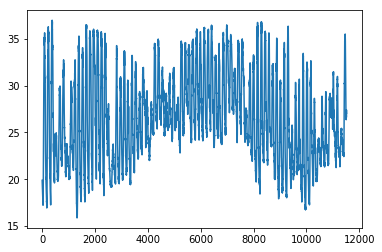

In [25]:
plt.plot(res)

np.log10(100.)
f = lambda x : np.log10(x)
train[''].apply(f) 

In [ ]:
import catboost as cb

lm=cb.CatBoostRegressor(max_depth=9, subsample= 0.8,eval_metric='MAE', n_estimators=1500)
models=lm.fit(x_train,y_train,verbose=100)

In [ ]:
y1_pred=models.predict(x_test)

In [ ]:
print( r2_score(y1_pred, y_test), mean_squared_error(y1_pred, y_test))